### data import
- Data is downloaded and converted to pickle file
- [Download location](http://yann.lecun.com/exdb/mnist/)
- Extraction using mlxtend library. sample code [reference](http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/)

### code for importing and converting the data into pickle files

The original dataset as imported from website which contributes the dataset for public usage is in unsigned byte format. The dataset is in flattened format and has single channel 28\*28 images flattened row-wise. The images are rebuilt using one of the many codes contributed by various users working on the same dataset.

For ease of use, here we have converted the dataset to standard pickle format as the library is generally more readily available on most platforms when compared to the mlxtend library originally mentioned. 

```python
from mlxtend.data import loa local_mnist
import pickle as pkl

X, y = loadlocal_mnist(
        images_path='data/MNIST/train-images-idx3-ubyte', 
        labels_path='data/MNIST/train-labels-idx1-ubyte')

pkl.dump((X, y), open('data/MNIST/data.pkl', 'wb'))
```

In [1]:
import pickle as pkl

In [2]:
X, y = pkl.load(open('data/MNIST/data.pkl', 'rb'))
X.shape, y.shape

((60000, 784), (60000,))

### Data Processing
- convert data to the appropriate format and check the label against sample instances for validation.
- data is presented in a single row vector as flattened values for 28\*28 images

In [3]:
import matplotlib.pyplot as plt
import random

### Validation Plot

Plotting dataset and checking corresponding labels to ensure validity of the code that is rebuilding the dataset from original ubyte dateset downloaded. The samples are picked at random to ensure that data at random are correctly labelled and the code is working fine in rebuilding the images from flattened vectors.

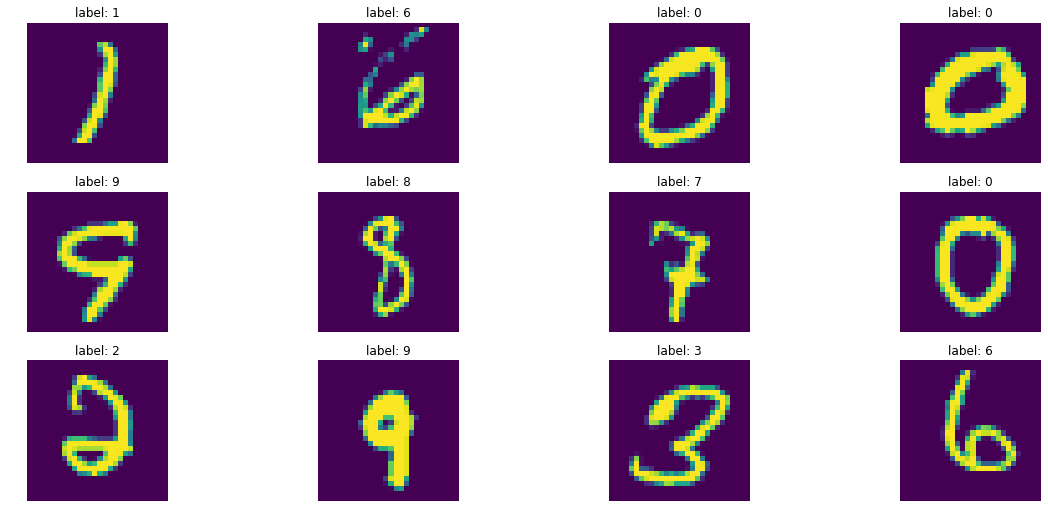

In [4]:
plt.figure(figsize=(20, 15))
for _ in range(12):
    idx = random.randint(0, len(X)-1)
    image_row_vector = X[idx]
    plt.subplot(5, 4, _+1)
    plt.imshow(image_row_vector.reshape((28, 28, 1)).squeeze())
    plt.title("label: {}".format(y[idx]))
    plt.axis('off')
plt.show()

### DCGAN

- Reference: https://github.com/pytorch/examples/blob/master/dcgan/main.py

Main idea of DCGAN lies in the terms of giving architecture guidelines to ensure stable training of GANs on CNNs. The main guidelines as summarized in the paper by the authors involve:

- replace any pooling layer with strided convolutions in discriminator and fractional-strided convolutions in generator
- batchnorm in both generator and discriminator
- no fully connected hidden layers in deep networks
- ReLU in generator for all layers but output layer which has Tanh activation
- LeakyReLU in discriminator for all layers

In [5]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
import torchvision.utils as vutils
import torchvision.transforms as transforms

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("DType: {}\nCuda available: {}\nDevice: {}".format(
    dtype.__str__(),
    torch.cuda.is_available().__str__(),
    device.__str__(),
))

DType: torch.float32
Cuda available: True
Device: cuda


- custom weight initialization called on the discriminator and generator networks.

### Scaling for Normalization

Ideally this should be done at a batch level for larger dataset but here since the providers give the entire dataset in a single matrix it is possible to do this scaling for the entire dataset at one go.

There can be various options for scaling which includes Standard Scaling as well. I have used MinMax Scaling because of the ease of use and it is generally shown to maintain the distribution and work well with outliers.

In [6]:
scaler = MinMaxScaler()
scaler.fit(X)
X_normalized = scaler.transform(X)
X_normalized.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(60000, 784)

### Validation Plot

To check if the images are affected at all by any of the normalization techniques which might be applied in the previous step, we plot and check visually for randomly picked elements that the images maintain their structure as they would have in the original scale image.

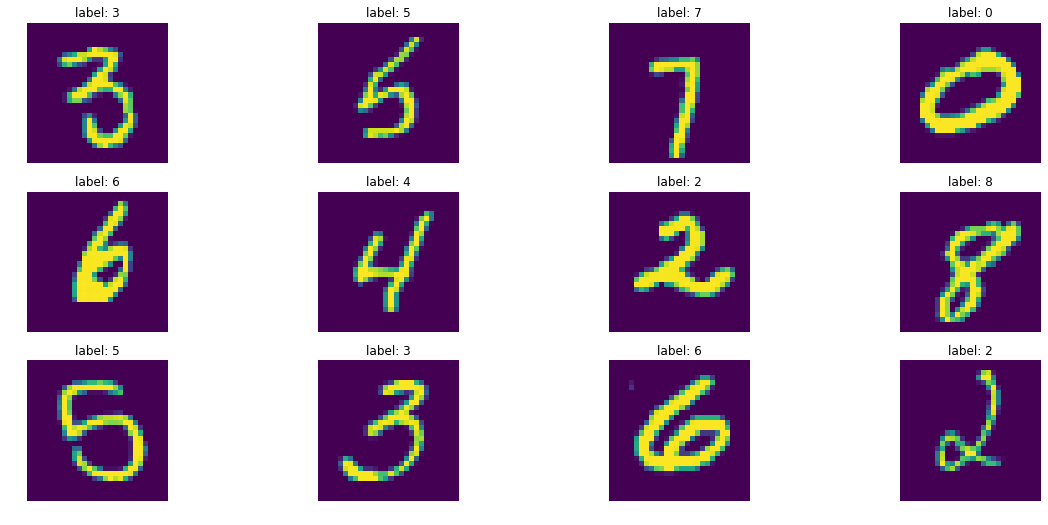

In [7]:
plt.figure(figsize=(20, 15))
for _ in range(12):
    idx = random.randint(0, len(X)-1)
    image_row_vector = X_normalized[idx]
    plt.subplot(5, 4, _+1)
    plt.imshow(image_row_vector.reshape((28, 28, 1)).squeeze())
    plt.title("label: {}".format(y[idx]))
    plt.axis('off')
plt.show()

### Constants Explained

- nz: encoding dimension
- ngf: generator filters that are scaled by factors 2, 4, 8 etc.
- ndf: disciminator filter similar to ngf
- nc: number of channels
- ngpu: number of physical gpus on system
- batchSize: number of instances for SGD

In [8]:
nz = 50
ngf = 56
ndf = 112
nc = 1
ngpu = 1
batchSize = 64

In [9]:
from torchsummary import summary

### Weights and Bias Initialization

- It has been shown heuristically that weights intialized normally tend to perform better when compared to random initialization. So the first function tries to achieve this goal.

- In the definition of Generator and Discriminator, sometimes the number of strides, kernel_size and pooling is adjusted to meet the final size of the output desired. 

- It can be seen that there are no fully connected layers in both G and D
- Also batchnorm is applied on all layers 
- ReLU on each layer except output
- Tanh on output layer

Reference: https://github.com/pytorch/examples/tree/master/dcgan

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        

![](static/dcgan_mnist_DCGaN.png)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(

            nn.ConvTranspose2d(nz, ngf * 8, 2, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 2, 2, 2,bias=False),
            nn.Tanh()
        )

    def forward(self, input):
            return self.main(input)

netG = Generator().to(device)
netG.apply(weights_init)

summary(netG, input_size=(50, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 448, 2, 2]          89,600
       BatchNorm2d-2            [-1, 448, 2, 2]             896
              ReLU-3            [-1, 448, 2, 2]               0
   ConvTranspose2d-4            [-1, 224, 4, 4]       1,605,632
       BatchNorm2d-5            [-1, 224, 4, 4]             448
              ReLU-6            [-1, 224, 4, 4]               0
   ConvTranspose2d-7            [-1, 112, 8, 8]         401,408
       BatchNorm2d-8            [-1, 112, 8, 8]             224
              ReLU-9            [-1, 112, 8, 8]               0
  ConvTranspose2d-10           [-1, 56, 16, 16]         100,352
      BatchNorm2d-11           [-1, 56, 16, 16]             112
             ReLU-12           [-1, 56, 16, 16]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]             224
             Tanh-14            [-1, 1,

Similarly,

- LeakyReLU on each layer
- BatchNorm on each layer
- Sigmoid in last layer to ensure probabilistic output 
- Sigmoid helps apply the BCE criterion at the end on the loss for optimizer
- BCE is binary cross-entropy loss function

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 2, 2, 2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

summary(netD, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 112, 16, 16]             448
         LeakyReLU-2          [-1, 112, 16, 16]               0
            Conv2d-3            [-1, 224, 8, 8]         401,408
       BatchNorm2d-4            [-1, 224, 8, 8]             448
         LeakyReLU-5            [-1, 224, 8, 8]               0
            Conv2d-6            [-1, 448, 4, 4]       1,605,632
       BatchNorm2d-7            [-1, 448, 4, 4]             896
         LeakyReLU-8            [-1, 448, 4, 4]               0
            Conv2d-9            [-1, 896, 2, 2]       6,422,528
      BatchNorm2d-10            [-1, 896, 2, 2]           1,792
        LeakyReLU-11            [-1, 896, 2, 2]               0
           Conv2d-12              [-1, 1, 1, 1]           3,584
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 8,436,736
Trainable param

In [12]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Create dataset and load

- Fixing the batchsize after creating dataset

In [13]:
dataset = utils.TensorDataset(torch.Tensor(X.reshape(-1, 1, 28, 28)), torch.Tensor(y))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=2)

### Model Parameters

- need to tweak the values of learning rate for generator and discriminator
- if the value is not optimal, discriminator might converge too soon and then generator will collapse 
- so the parameter tweaking is a must to find the right balance

In [14]:
niter = 20
outf = 'result/DCGAN_MNIST'

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i %100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    if epoch % 2 == 0:
        vutils.save_image(real_cpu,
                '%s/real_samples.png' % outf,
                normalize=True)
        fake = netG(fixed_noise)
        vutils.save_image(fake.detach(),
                '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                normalize=True)

[0/20][0/938] Loss_D: 1.8658 Loss_G: 15.4858 D(x): 0.3312 D(G(z)): 0.4515 / 0.0000
[0/20][100/938] Loss_D: 0.0288 Loss_G: 4.2341 D(x): 0.9939 D(G(z)): 0.0224 / 0.0154
[0/20][200/938] Loss_D: 0.0210 Loss_G: 5.7556 D(x): 0.9856 D(G(z)): 0.0061 / 0.0035
[0/20][300/938] Loss_D: 3.6986 Loss_G: 8.7081 D(x): 0.1562 D(G(z)): 0.0005 / 0.0071
[0/20][400/938] Loss_D: 0.1277 Loss_G: 1.8511 D(x): 0.9948 D(G(z)): 0.1092 / 0.1825
[0/20][500/938] Loss_D: 0.2877 Loss_G: 6.5951 D(x): 0.8259 D(G(z)): 0.0049 / 0.0021
[0/20][600/938] Loss_D: 0.0019 Loss_G: 8.6352 D(x): 1.0000 D(G(z)): 0.0019 / 0.0052
[0/20][700/938] Loss_D: 0.0659 Loss_G: 13.4497 D(x): 0.9497 D(G(z)): 0.0000 / 0.0000
[0/20][800/938] Loss_D: 0.0245 Loss_G: 7.7117 D(x): 0.9831 D(G(z)): 0.0061 / 0.0005
[0/20][900/938] Loss_D: 0.1562 Loss_G: 13.9877 D(x): 0.9304 D(G(z)): 0.0001 / 0.0001
[1/20][0/938] Loss_D: 0.0723 Loss_G: 6.3860 D(x): 0.9663 D(G(z)): 0.0238 / 0.0037
[1/20][100/938] Loss_D: 0.0371 Loss_G: 5.2609 D(x): 0.9857 D(G(z)): 0.0220 / 

[9/20][800/938] Loss_D: 0.2522 Loss_G: 3.1337 D(x): 0.8998 D(G(z)): 0.1189 / 0.0659
[9/20][900/938] Loss_D: 0.1721 Loss_G: 5.0729 D(x): 0.9293 D(G(z)): 0.0847 / 0.0101
[10/20][0/938] Loss_D: 2.3182 Loss_G: 8.2604 D(x): 0.9970 D(G(z)): 0.8283 / 0.0005
[10/20][100/938] Loss_D: 0.1871 Loss_G: 4.1433 D(x): 0.8704 D(G(z)): 0.0171 / 0.0426
[10/20][200/938] Loss_D: 0.7566 Loss_G: 2.5517 D(x): 0.6242 D(G(z)): 0.1023 / 0.1045
[10/20][300/938] Loss_D: 0.0796 Loss_G: 5.2140 D(x): 0.9779 D(G(z)): 0.0516 / 0.0102
[10/20][400/938] Loss_D: 1.5674 Loss_G: 14.6118 D(x): 0.9980 D(G(z)): 0.6838 / 0.0000
[10/20][500/938] Loss_D: 0.1218 Loss_G: 4.5850 D(x): 0.9412 D(G(z)): 0.0521 / 0.0178
[10/20][600/938] Loss_D: 1.0281 Loss_G: 1.2324 D(x): 0.4627 D(G(z)): 0.0536 / 0.3857
[10/20][700/938] Loss_D: 0.2118 Loss_G: 2.8860 D(x): 0.8716 D(G(z)): 0.0477 / 0.0834
[10/20][800/938] Loss_D: 0.9585 Loss_G: 0.7673 D(x): 0.4892 D(G(z)): 0.0088 / 0.5255
[10/20][900/938] Loss_D: 0.4677 Loss_G: 5.4330 D(x): 0.9465 D(G(z)):

[19/20][500/938] Loss_D: 0.0653 Loss_G: 5.8399 D(x): 0.9611 D(G(z)): 0.0199 / 0.0095
[19/20][600/938] Loss_D: 0.0882 Loss_G: 4.9506 D(x): 0.9326 D(G(z)): 0.0118 / 0.0189
[19/20][700/938] Loss_D: 0.4380 Loss_G: 3.5261 D(x): 0.7171 D(G(z)): 0.0054 / 0.0980
[19/20][800/938] Loss_D: 0.1749 Loss_G: 6.0484 D(x): 0.9918 D(G(z)): 0.1330 / 0.0038
[19/20][900/938] Loss_D: 0.3138 Loss_G: 4.7994 D(x): 0.8150 D(G(z)): 0.0417 / 0.0219


### Save Model

In [15]:
torch.save(netD, 'models/netD.pkl')
torch.save(netG, 'models/netG.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 0th Epoch
<img src="result/DCGAN_MNIST/fake_samples_epoch_000.png" width=400>

### 4th Epoch
<img src="result/DCGAN_MNIST/fake_samples_epoch_004.png" width=400>

### 8th Epoch
<img src="result/DCGAN_MNIST/fake_samples_epoch_008.png" width=400>

### 12th Epoch
<img src="result/DCGAN_MNIST/fake_samples_epoch_012.png" width=400>

### 18th Epoch
<img src="result/DCGAN_MNIST/fake_samples_epoch_018.png" width=400>

### Testing

Try to see if there are any patterns in the random walks generated

In [ ]:
fn_1 = torch.randn(1, nz, 1, 1, device=device)
fn_2 = torch.randn(1, nz, 1, 1, device=device)
fn_r = torch.cat((fn_1, fn_2, (fn_1+fn_2)/2), 0)
fk_r = netG(fn_r)
fk_1.shape, fk_2.shape, fk_r.shape

vutils.save_image(fk_r.detach(),
                '%s/%s.png' % (outf, 'fk_test'),
                normalize=True)

<img src="result/DCGAN_MNIST/fk_test.png" width=400/>